In [1]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver("GUROBI_LP")

print(solver)

<ortools.linear_solver.pywraplp.Solver; proxy of <Swig Object of type 'operations_research::MPSolver *' at 0x7fdf5c73f0f0> >


In [19]:
df = pd.read_csv(PROJECT_ROOT / "data" / "cville_dem.txt")

In [20]:
df.head()

,pid,hid,age,age_group,gender,county_fips,home_latitude,home_longitude,employment_status,occupation_socp,hh_size,hh_income,household_language,workers_in_family,race,hispanic
0,30923,13480,50,o,2,51003,38.09230,-78.435006,1.0,291141,4,242400,1,3,1,1
1,30924,13480,55,o,1,51003,38.09230,-78.435006,1.0,112020,4,242400,1,3,1,1
2,30925,13480,23,a,1,51003,38.09230,-78.435006,1.0,252050,4,242400,1,3,1,1
3,30926,13480,17,s,1,51003,38.09230,-78.435006,3.0,3590XX,4,242400,1,3,1,1
4,30927,13481,27,a,2,51003,38.09787,-78.415067,1.0,351012,2,30600,1,2,5,1


In [21]:
df['age_group'].value_counts()

a    57932
o    27680
g    21797
s    20191
p     7088
Name: age_group, dtype: int64

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

# New Imports
from ctrace.contact_tracing import *
from ctrace.constraint import *
from ctrace.solve import *
from ctrace.simulation import *
from ctrace.restricted import *

In [2]:
S = set()
I = set()
R = set()

with open(PROJECT_ROOT / "data" / "SIR_Cache" / 'a5.json', 'r') as infile:
            j = json.load(infile)
            (S, infected_queue, R) = (
                set(j["S"]), j["I_Queue"], set(j["R"]))
            infected_queue = [set(s) for s in infected_queue]
            I = I.union(*infected_queue)

In [5]:
V_1,V_2 = find_excluded_contours(G2,I,R)

In [6]:
P,Q = PQ_deterministic(G2,I,V_1,.06)

In [13]:
rprob1 = r_get_prob(G2, I, R, 500, .06, rev_nodes, policy='equal')
rprob2 = r_get_prob(G2, I, R, 1000, .06, rev_nodes, policy='old')
rprob3 = r_get_prob(G2, I, R, 1500, .06, rev_nodes, policy='adult')

In [34]:
df = pd.read_csv(PROJECT_ROOT / "data" / "cville_dem.txt")
unique = df['age_group'].unique()
map_label = {}

for i, group in enumerate(unique):
    map_label[group] = i

#generate label dict for V_1 
labels = {i: map_label[df[df.pid==rev_nodes[i]]['age_group'].item()] for i in V_1}

#generate label limits by our definition of fairness
label_limits = [0 for _ in range(len(map_label.keys()))]


for i in V_1:
    label_limits[labels[i]]+=1

In [8]:
prob1 = ProbMinExposed(G2,I,V_1,V_2,P,Q,500)
prob2 = ProbMinExposed(G2,I,V_1,V_2,P,Q,1000)
prob3 = ProbMinExposed(G2,I,V_1,V_2,P,Q,1500)
prob4 = ProbMinExposed(G2,I,V_1,V_2,P,Q,2000)

In [75]:
B=1000
count = [0,0,0,0,0]

(_,rec) = to_quarantine(G2,I,R,B,method='weighted',p=.06)
for (k,v) in rec.items():
    count[rprob1.labels[k]] += v

print(count)

angles = np.linspace(0, 2 * np.pi, points, endpoint=False).tolist()
angles += angles[:1]

probA = r_get_prob(G2, I, R, B, .06, rev_nodes, policy='equal')
probB = r_get_prob(G2, I, R, B, .06, rev_nodes, policy='old')
probC = r_get_prob(G2, I, R, B, .06, rev_nodes, policy='adult')


[194, 492, 200, 60, 54]


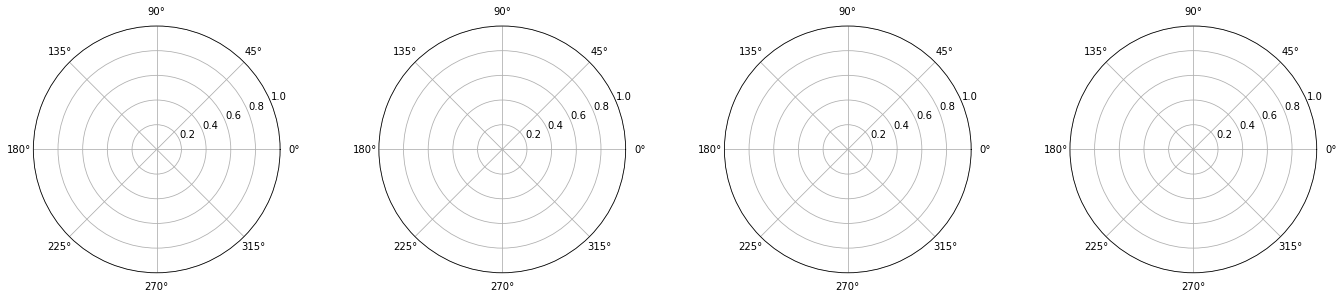

In [135]:
fig, ax = plt.subplots(1,4,figsize=(23, 6), subplot_kw=dict(polar=True))
plt.subplots_adjust(wspace = .4)
points = 5

In [136]:
ax[3].plot(angles, list(100.0*probA.label_limits/label_limits) + list(100.0*probA.label_limits[:1]/label_limits[:1]), color='red', linewidth=1,label='D')
ax[3].fill(angles, list(100.0*probA.label_limits/label_limits) + list(100.0*probA.label_limits[:1]/label_limits[:1]), color='red', alpha=0.45)

ax[1].plot(angles, list(100.0*probB.label_limits/label_limits) + list(100.0*probB.label_limits[:1]/label_limits[:1]), color='orange', linewidth=1,label='B')
ax[1].fill(angles, list(100.0*probB.label_limits/label_limits) + list(100.0*probB.label_limits[:1]/label_limits[:1]), color='orange', alpha=0.45)

ax[2].plot(angles, list(100.0*probC.label_limits/label_limits) + list(100.0*probC.label_limits[:1]/label_limits[:1]), color='green', linewidth=1,label='C')
ax[2].fill(angles, list(100.0*probC.label_limits/label_limits) + list(100.0*probC.label_limits[:1]/label_limits[:1]), color='green', alpha=0.45)

ax[0].plot(angles, list(100.0*np.array(count)/label_limits) + list(100.0*np.array(count[:1])/label_limits[:1]), color='blue', linewidth=1,label='A')
ax[0].fill(angles, list(100.0*np.array(count)/label_limits) + list(100.0*np.array(count[:1])/label_limits[:1]), color='blue', alpha=0.45)

In [143]:
for i in [0,1,2,3]:
    ax[i].set_thetagrids(np.degrees(angles), list(df['age_group'].unique()) + list(df['age_group'].unique()[:1]),fontsize=36)
    ax[i].set_rgrids([2, 4, 6, 8, 10],fontsize=30)
    ax[i].grid(linewidth=1.2,color='#000000')
    ax[i].spines['polar'].set_color('black')
    ax[i].spines['polar'].set_linewidth(3)
    ax[i].spines['polar'].set_linestyle('-')
        #ax[i][j].

In [138]:
fig.tight_layout()
fig.subplots_adjust(wspace=.3)

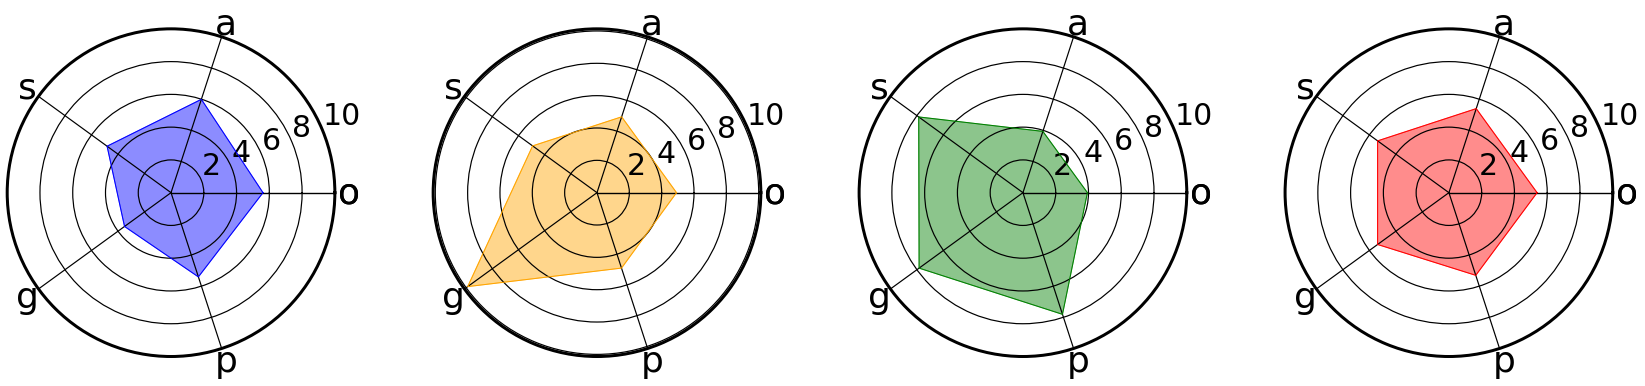

In [144]:
fig

In [145]:
fig.savefig("../output/plots/star_1000_v4",dpi=400)

In [16]:
probA.label_limits + probA.label_limits[:1]

array([186., 314., 204., 139., 119.])

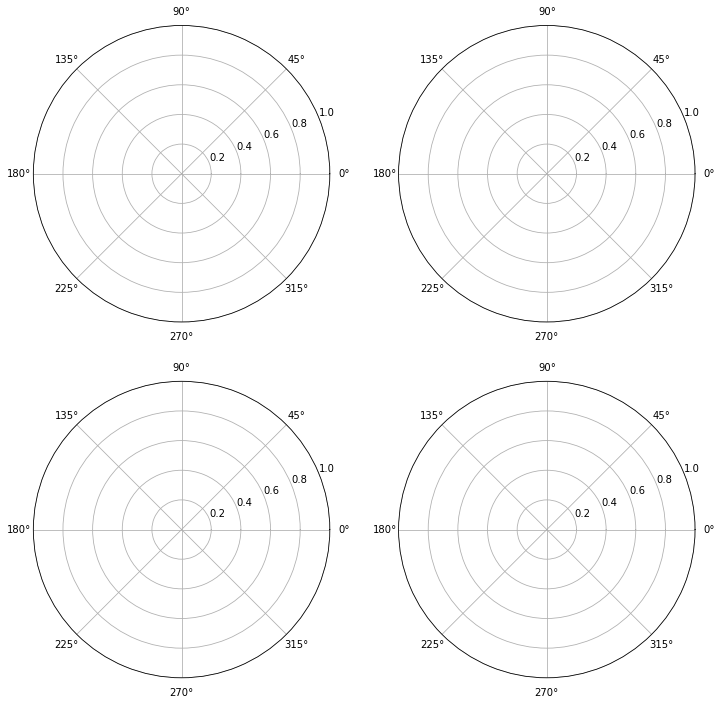

In [56]:
fig, ax = plt.subplots(2,2,figsize=(12, 12), subplot_kw=dict(polar=True))
points = 5


In [58]:
ax

array([[<PolarAxesSubplot:>, <PolarAxesSubplot:>],
       [<PolarAxesSubplot:>, <PolarAxesSubplot:>]], dtype=object)

In [51]:
angles = np.linspace(0, 2 * np.pi, points, endpoint=False).tolist()
angles += angles[:1]

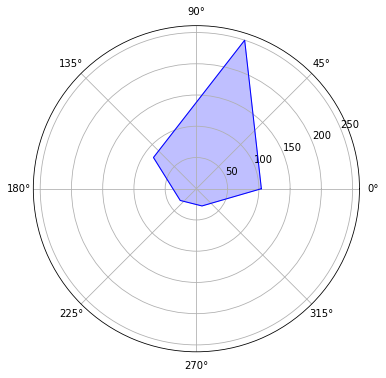

In [52]:
ax.plot(angles, count + count[:1], color='blue', linewidth=1, label='hi')
ax.fill(angles, count + count[:1], color='blue', alpha=0.25)
fig

In [30]:
count

[104, 250, 85, 32, 29]

In [24]:
rprob1.label_limits

array([ 68., 161., 163.,  67.,  39.])

In [4]:
G2 = nx.Graph()
G2.NAME = "able"
nodes = {}
rev_nodes = []

file = open("../data/undirected_albe_1.90.txt", "r")
file.readline()
lines = file.readlines()
c = 0
c_node=0
ma = 0
mi = 100000000

for line in lines:

    a = line.split()
    u = int(a[1])
    v = int(a[2])
    if u > ma:
        ma = u
    if u < mi:
        mi = u
    if v > ma:
        ma = u
    if v < mi:
        mi = u
        
    if u in nodes.keys():
        u = nodes[u]
    else:
        nodes[u] = c_node
        rev_nodes.append(u)
        u = c_node
        c_node+=1        
    
    if v in nodes.keys():
        v = nodes[v]
    else:
        nodes[v] = c_node
        rev_nodes.append(v)
        v = c_node
        c_node+=1

    G2.add_edge(u,v)

In [4]:
G = load_graph("montgomery")
print(len(G.edges))

648667


In [10]:
a = list(sorted(G2.degree, key=lambda x: x[1], reverse=True))
a[0]

(1174, 176)

In [75]:
df5 = pd.read_csv("../output/run[KorCn]/results.csv")
df5 = pd.concat([df5[df5.budget==500],df5[df5.budget==1000],df5[df5.budget==1500],df5[df5.budget==2000]])
df5=df5[df5.method=='weighted']
df5['policy'] = 'none'
df5 = df5.reset_index()
df5 = df5.sort_values(by='budget')

In [105]:
df1 = pd.read_csv("../output/run[kvDZ7]/results.csv")
df1['policy'] = 'equal'
df1 = df1.sort_values(by='budget')

df2 = pd.read_csv("../output/run[BUqYH]/results.csv")
df2 = df2.sort_values(by='budget')
df2['policy'] = 'more old'
#df2['infected'] = df2['infected'] - df5['infected']

df3 = pd.read_csv("../output/run[aaSdN]/results.csv")
df3 = df3.sort_values(by='budget')
df3['policy'] = 'more students'
#df3['infected'] = df3['infected'] - df5['infected']

df4 = pd.read_csv("../output/run[nUGDZ]/results.csv")
df4 = df4.sort_values(by='budget')
df4['policy'] = 'less working class'
#df4['infected'] = df4['infected'] - df5['infected']

#df5['infected'] = df5['infected'] - df5['infected']

df = pd.concat([df1,df2,df4,df5])
df['infected'] = 100.0*df['infected']/131219
#df5['infected'] = df5['infected']/131219

In [106]:
df = df.replace({'equal':'A','more old' : 'B', 'less working class' : 'C', 'none' : "D"})

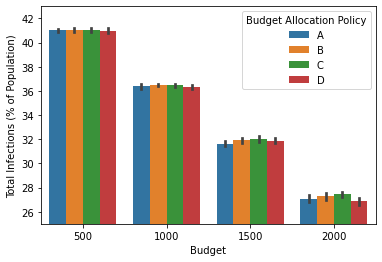

In [108]:
sns.barplot(data=df,x='budget',y='infected',hue='policy')
plt.legend(title="Budget Allocation Policy")
plt.ylabel("Total Infections (% of Population)")
plt.xlabel("Budget")
plt.ylim(25,43)
plt.savefig("../output/plots/compare_policy.png",dpi=300)

In [78]:
df1['infected'] = df1['infected'] - df5['infected']
df2['infected'] = df2['infected'] - df5['infected']
df3['infected'] = df3['infected'] - df5['infected']
df4['infected'] = df4['infected'] - df5['infected']
df = pd.concat([df1,df2,df3,df4])

<AxesSubplot:xlabel='budget', ylabel='infected'>

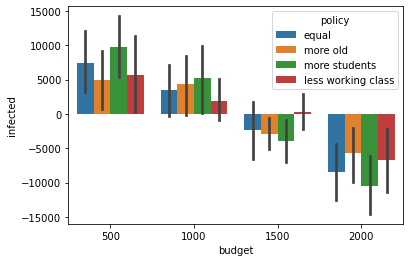

In [79]:
sns.barplot(data=df,x='budget',y='infected',hue='policy')
#plt.ylim([32000,55000])
#sns.lineplot(data=df2,x='budget',y='infected')
#sns.lineplot(data=df3,x='budget',y='infected')

19    53235
29    53368
19    53379
1     53445
22    53462
16    53502
2     53539
24    53615
6     53646
0     53680
5     53744
8     53757
0     53763
8     53804
37    53805
30    53830
2     53859
33    53875
34    53969
24    53974
0     53975
26    54018
22    54026
3     54060
17    54063
38    54150
30    54175
4     54250
7     54265
26    54350
Name: infected, dtype: int64

<======= SIR Initialization Complete =======>
6 126850 2993 1376 2993
7 119317 6080 4369 6080
8 108185 10064 10449 10064
9 92924 14385 20513 14385
10 76484 15666 34898 15666
11 64240 11578 50564 11578
12 57651 6059 62142 6059
13 54637 2565 68201 2565
14 53276 909 70766 909
15 52510 274 71675 274
16 51573 43 71949 43
17 51272 0 71992 0


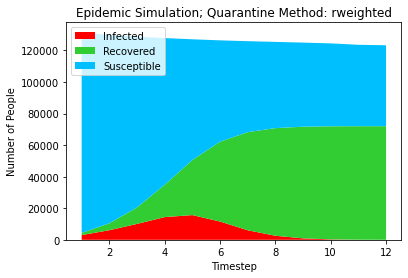

SIM_RETURN(num_contracted=71992, peak_infected=15666, simulation_length=17)

In [5]:

for (ind, k) in enumerate([500,1000,1500,2000]):
    val = 0
    
    for i in range(10):
        a[0] = r_mdp(G=G2, 
              p=.1, 
              budget=k, 
              method="rweighted", 
              MDP_iterations=-1, 
              num_shocks=15, 
              num_initial_infections=9, 
              initial_iterations=5, 
              iterations_to_recover=1,
              rev_nodes=rev_nodes, 
              cache=None, 
              from_cache='a5.json',
              verbose=False,
              visualization=False)
        val += a[0]
        
    val/=10
    
    

In [34]:
prob = r_get_prob(G2, I, [], k, p)

In [9]:
b=0
c=0
for i in range(10):
    a = r_mdp(G=G2, 
      p=.1, 
      budget=2000, 
      method="rrandom", 
      MDP_iterations=-1, 
      num_shocks=15, 
      num_initial_infections=9, 
      initial_iterations=5, 
      iterations_to_recover=1,
      rev_nodes=rev_nodes, 
      cache=None, 
      from_cache='a5.json',
      verbose=False,
      visualization=False)
    c+= a[0]
    b += a[1]
    print(a[0],a[1])
    
print(b,c)

74383 17729
74319 17969
74089 17727
74185 17579
74373 17744
74288 17538
74231 17603
74170 17603
74347 17357
74738 17873
176722 743123


In [51]:

generalized_mdp(G=G2, 
      p=.06, 
      budget=510, 
      method="dependent", 
      MDP_iterations=-1, 
      num_shocks=15, 
      num_initial_infections=9, 
      initial_iterations=5, 
      iterations_to_recover=1,
      cache=None, 
      from_cache='a5.json',
      verbose=False,
      visualization=False)

SIM_RETURN(num_contracted=54737, peak_infected=8474, simulation_length=21)

In [52]:

generalized_mdp(G=G2, 
      p=.06, 
      budget=520, 
      method="dependent", 
      MDP_iterations=-1, 
      num_shocks=15, 
      num_initial_infections=9, 
      initial_iterations=5, 
      iterations_to_recover=1,
      cache=None, 
      from_cache='a5.json',
      verbose=False,
      visualization=False)

SIM_RETURN(num_contracted=54587, peak_infected=8183, simulation_length=22)

In [53]:

generalized_mdp(G=G2, 
      p=.06, 
      budget=530, 
      method="dependent", 
      MDP_iterations=-1, 
      num_shocks=15, 
      num_initial_infections=9, 
      initial_iterations=5, 
      iterations_to_recover=1,
      cache=None, 
      from_cache='a5.json',
      verbose=False,
      visualization=False)

SIM_RETURN(num_contracted=54405, peak_infected=8458, simulation_length=22)

# All The Plots

## Labelled CVille Plots

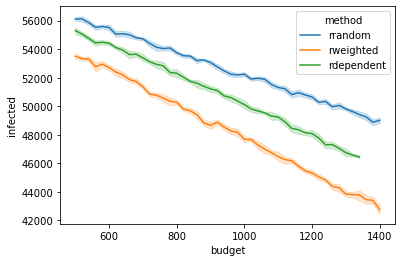

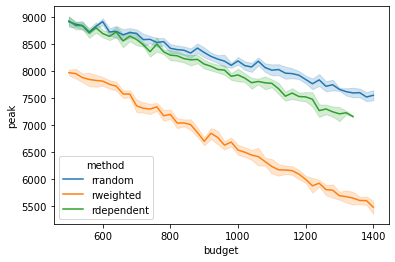

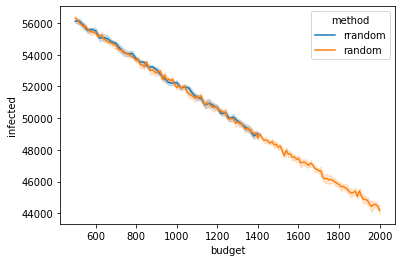

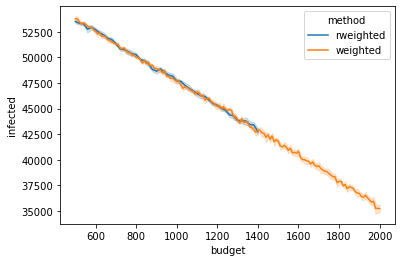

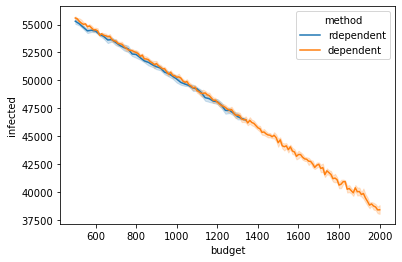

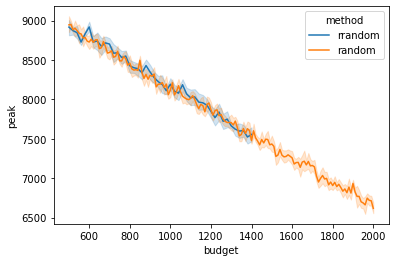

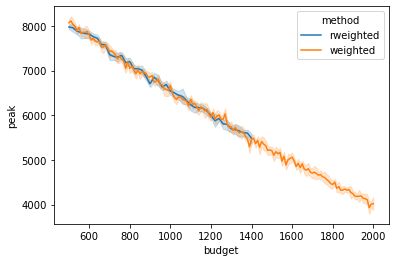

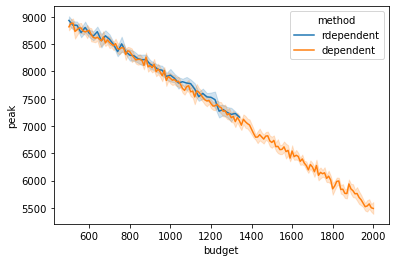

In [7]:
df = pd.read_csv("../output/run[3FFvL]/results.csv")

#comparison of different methods
sns.lineplot(data=df,x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=df,x="budget",y="peak",hue="method")
plt.show()

df2 = pd.read_csv("../output/run[KorCn]/results.csv")
df = pd.concat([df,df2])

#comparison of total between labelled + normal
sns.lineplot(data=pd.concat([df[df.method == 'rrandom'],df[df.method == 'random']]),x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=pd.concat([df[df.method == 'rweighted'],df[df.method == 'weighted']]),x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=pd.concat([df[df.method == 'rdependent'],df[df.method == 'dependent']]),x="budget",y="infected",hue="method")
plt.show()

#comparison of peak between labelled + normal
sns.lineplot(data=pd.concat([df[df.method == 'rrandom'],df[df.method == 'random']]),x="budget",y="peak",hue="method")
plt.show()
sns.lineplot(data=pd.concat([df[df.method == 'rweighted'],df[df.method == 'weighted']]),x="budget",y="peak",hue="method")
plt.show()
sns.lineplot(data=pd.concat([df[df.method == 'rdependent'],df[df.method == 'dependent']]),x="budget",y="peak",hue="method")
plt.show()

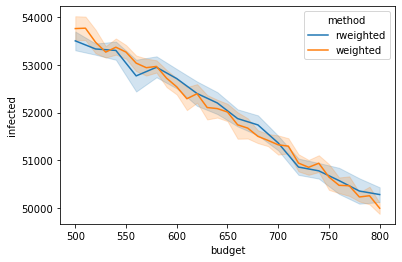

In [3]:
df=df[df.budget<=800]
sns.lineplot(data=pd.concat([df[df.method == 'rweighted'],df[df.method == 'weighted']]),x="budget",y="infected",hue="method")
plt.show()

## Random Cville Plots showing that something may be broken

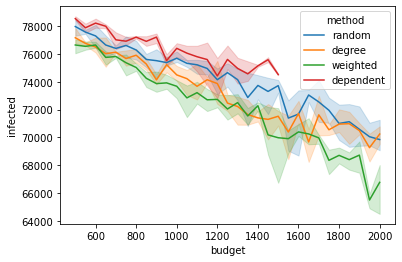

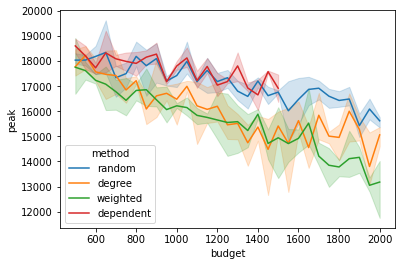

In [80]:
df = pd.read_csv("../output/run[mzPxQ]/results.csv")

sns.lineplot(data=df,x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=df,x="budget",y="peak",hue="method")
plt.show()


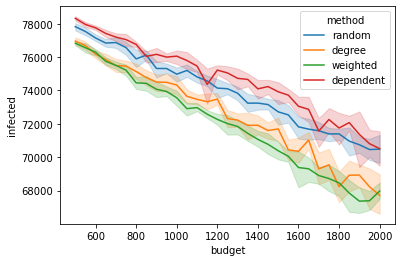

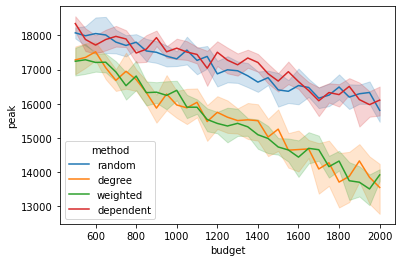

In [3]:
df = pd.read_csv("../output/run[DZQi5]/results.csv")

sns.lineplot(data=df,x="budget",y="infected",hue="method")
plt.show()
sns.lineplot(data=df,x="budget",y="peak",hue="method")
plt.show()

## Vary k, Montgomery

In [11]:
df2 = pd.read_csv("../output/run[358qP]/results.csv")
df2[df2.method=='degree'].head()

,G,budget,method,MDP_iterations,iterations_to_recover,p,initial_iterations,from_cache,num_initial_infections,num_shocks,infected,peak,iterations_completed
10,montgomery,60,degree,-1,1,0.078,7,t7.json,5,8,35607,5869,22
11,montgomery,60,degree,-1,1,0.078,7,t7.json,5,8,35204,5672,22
12,montgomery,60,degree,-1,1,0.078,7,t7.json,5,8,35346,5758,22
13,montgomery,60,degree,-1,1,0.078,7,t7.json,5,8,35555,5888,22
14,montgomery,60,degree,-1,1,0.078,7,t7.json,5,8,35232,5823,22


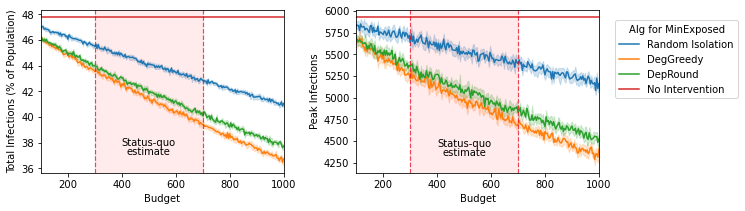

In [226]:
df2 = pd.read_csv("../output/run[358qP]/results.csv")
#df1 = pd.read_csv("../output/run[hdVJE]/results.csv")
#df = pd.concat([df,df1])
#df = pd.concat([df[df.method == 'random'],df[df.method == 'dependent'],df[df.method == 'weighted']])
df = pd.read_csv("../output/run[TyTjV]/results.csv")
df = df.replace({'random':'Random Sol', 'dependent':'DepRound', 'weighted':'DegGreedy'})
df = df.rename(columns={"method":"Alg for MinExposed"})
#print(df.head())
df['infected'] = 100.0*df['infected']/75457


a = df.loc[:1,:].copy()
a.loc[[0],['budget']] = 1000
a.loc[0,'infected'] = 100.0*36061/75457
a.loc[1,'infected'] = 100.0*36061/75457
a.loc[0,'peak'] = 5927
a.loc[1,'peak'] = 5927
a.loc[[1],['Alg for MinExposed']] = 'No Intervention'
a.loc[[0],['Alg for MinExposed']] = 'No Intervention'

df = pd.concat([df,a]).reset_index()


fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace = .3)


ax0 = sns.lineplot(data=df,x="budget",y="infected",hue="Alg for MinExposed", ax=ax[0])
ax0.get_legend().remove()
ax[0].set_xlabel("Budget")
ax[0].set_ylabel("Total Infections (% of Population)")
ax[0].axvline(x=300, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
ax[0].axvline(x=700, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
ax[0].text(500, 38, 'Status-quo', fontsize=10,verticalalignment='center', horizontalalignment='center')
ax[0].text(500, 37.3, 'estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
ax[0].axvspan(300, 700, alpha=0.08, color='red')
ax[0].set_xlim(100,1000)
#ax[0].legend(loc="upper right",title="Alg for MinExposed")
#fig.savefig('../output/plots/Montgomery_vary_k_total.png', dpi=300)


ax1 = sns.lineplot(data=df,x="budget",y="peak",hue="Alg for MinExposed", ax=ax[1])
ax1.get_legend().remove()
ax[1].set_xlabel("Budget")
ax[1].set_ylabel("Peak Infections")
ax[1].axvline(x=300, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
ax[1].axvline(x=700, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
ax[1].text(500, 4470, 'Status-quo', fontsize=10,verticalalignment='center', horizontalalignment='center')
ax[1].text(500, 4370, 'estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
ax[1].axvspan(300, 700, alpha=0.08, color='red')
ax[1].set_xlim(100,1000)
#ax[1].legend(loc="upper right",title="Alg for MinExposed")
#fig.savefig('../output/plots/Montgomery_vary_k_peak.png', dpi=300)

fig.legend(['Random Isolation','DegGreedy','DepRound','No Intervention'],title='Alg for MinExposed',loc="right", bbox_to_anchor=(1.1,.65), prop={'size':10})
fig.savefig("../output/plots/combined_mont.png", dpi=300)
plt.show()

## Vary t, Montgomery

In [254]:
df = pd.read_csv("../output/run[4iX4Y]/results.csv")
df1 = pd.read_csv("../output/run[4iX4Y]/results1.csv")
df2 = pd.read_csv("../output/run[4iX4Y]/results2.csv")
df3 = pd.read_csv("../output/run[358qP]/results.csv")
df3['budget'] = df3['budget'].replace({252:250})
df = pd.concat([df,df1,df2,df3[df3.budget==500],df3[df3.budget==250]]).reset_index(drop=True)
df['t'] = df['from_cache'].str[1:-5].astype(int)
df['infected'] = 100.0*df['infected'] / 75457
df = df[df.method != 'degree']
df = df.replace({'random':'Random Sol', 'dependent':'DepRound', 'weighted':'DegGreedy'})


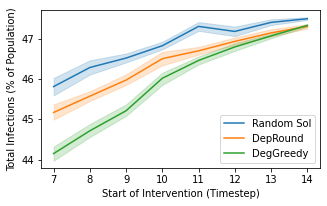

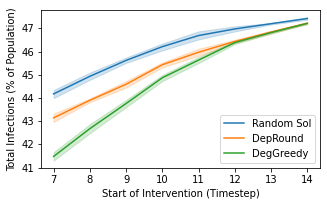

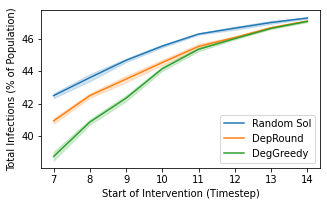

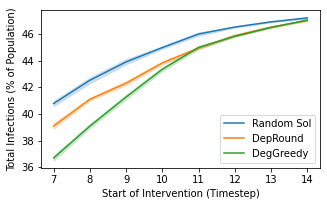

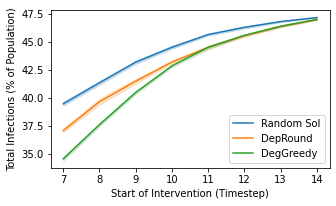

In [255]:
for k in [250,500,750,1000,1250]:
    fig, ax = plt.subplots(1,figsize=(5,3))
    sns.lineplot(data=df[df.budget==k],x="t",y="infected",hue="method", ax=ax)
    #ax.set_title(str(k))
    ax.set_ylabel("Total Infections (% of Population)")
    ax.set_xlabel("Start of Intervention (Timestep)")
    ax.legend(loc='lower right',title='')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.show()
    fig.savefig("../output/plots/vary_t_mont_" + str(k), dpi=300)
    
    #sns.lineplot(data=df[df.budget==k],x="t",y="peak",hue="method")
    #plt.title(str(k))
    #plt.show()

## Vary k, Charlottesville

(100.0, 1000.0)

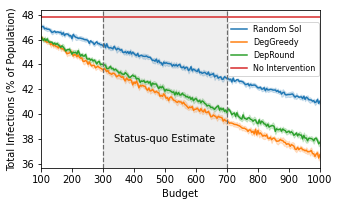

In [227]:
fig, ax = plt.subplots(1,figsize=(5,3))

ax = sns.lineplot(data=df,x="budget",y="infected",hue="Alg for MinExposed", ax=ax)
#ax.get_legend().remove()
ax.set_xlabel("Budget")
ax.set_ylabel("Total Infections (% of Population)")
ax.axvline(x=300, linewidth=1.2, color='dimgrey',linestyle='--')
ax.axvline(x=700, linewidth=1.2, color='dimgrey',linestyle='--')
ax.text(500, 38, 'Status-quo Estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
#ax.text(500, 37.3, 'estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
legend = ax.legend(loc="upper right",title="",prop={'size':8}, bbox_to_anchor=(1.01,.95))
plt.setp(legend.get_title(),fontsize=9)
ax.axvspan(300, 700, alpha=0.13, color='grey')
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlim(100,1000)

In [228]:
fig.savefig('../output/plots/Montgomery_vary_k_total.png', dpi=300)

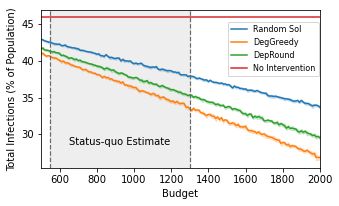

In [224]:
fig, ax = plt.subplots(1,figsize=(5,3))

sns.lineplot(data=df,x="budget",y="infected",hue="Alg for MinExposed",ax=ax)
ax.set_xlabel("Budget")
ax.set_ylabel("Total Infections (% of Population)")
legend = ax.legend(loc="upper right",title="",prop={'size':8},bbox_to_anchor=(1.01,.95))
plt.setp(legend.get_title(),fontsize=9)
ax.axvline(x=550, linewidth=1.2, color='dimgrey',linestyle='--')
ax.axvline(x=1300, linewidth=1.2, color='dimgrey',linestyle='--')
ax.text(925, 29, 'Status-quo Estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
#ax.text(925, 28, 'estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
ax.axvspan(550, 1300, alpha=0.13, color='grey')
ax.set_xlim(500,2000)
plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('../output/plots/Charlottesville_vary_k_total.png', dpi=300)
plt.show()

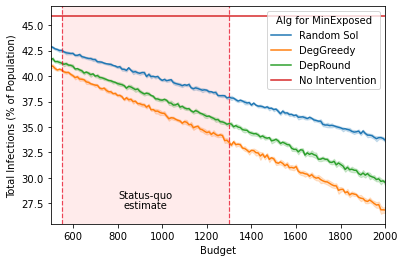

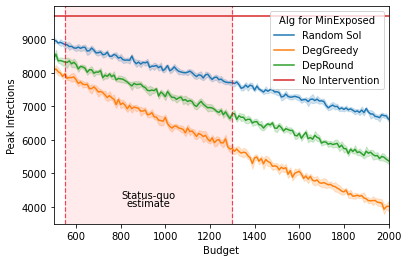

In [223]:
df = pd.read_csv("../output/run[KorCn]/results.csv")
df1 = pd.read_csv("../output/run[mxNiv]/results.csv")
df = pd.concat([df[df.method=='random'],df[df.method=='weighted'],df1])
df['infected'] = 100.0*df['infected']/131219
df = df.replace({'random':'Random Sol', 'dependent':'DepRound', 'weighted':'DegGreedy'})
df = df.rename(columns={"method":"Alg for MinExposed"})
df = df.reset_index()

a = df.loc[:1,:].copy()
a.loc[[0],['budget']] = 2000
a.loc[0,'infected'] = 100.0*60199/131219
a.loc[1,'infected'] = 100.0*60199/131219
a.loc[0,'peak'] = 9682
a.loc[1,'peak'] = 9682
a.loc[[1],['Alg for MinExposed']] = 'No Intervention'
a.loc[[0],['Alg for MinExposed']] = 'No Intervention'

df = pd.concat([df,a]).reset_index()

sns.lineplot(data=df,x="budget",y="infected",hue="Alg for MinExposed")
plt.xlabel("Budget")
plt.ylabel("Total Infections (% of Population)")
plt.legend(loc="upper right",title="Alg for MinExposed")
plt.axvline(x=550, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
plt.axvline(x=1300, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
plt.text(925, 28.3, 'Status-quo', fontsize=10,verticalalignment='center', horizontalalignment='center')
plt.text(925, 27.3, 'estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
plt.axvspan(550, 1300, alpha=0.08, color='red')
plt.xlim(500,2000)
plt.savefig('../output/plots/Charlottesville_vary_k_total.png', dpi=300)

plt.show()

sns.lineplot(data=df,x="budget",y="peak",hue="Alg for MinExposed")
plt.xlabel("Budget")
plt.ylabel("Peak Infections")
plt.axvline(x=550, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
plt.axvline(x=1300, linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
plt.text(925, 4340, 'Status-quo', fontsize=10,verticalalignment='center', horizontalalignment='center')
plt.text(925, 4100, 'estimate', fontsize=10,verticalalignment='center', horizontalalignment='center')
plt.legend(loc="upper right",title="Alg for MinExposed")
plt.axvspan(550, 1300, alpha=0.08, color='red')
plt.xlim(500,2000)
plt.savefig('../output/plots/Charlottesville_vary_k_peak.png', dpi=300)

plt.show()

## Vary t, Charlottesville

In [248]:
df = pd.read_csv("../output/run[DdbkN]/results.csv")
df1 = pd.read_csv("../output/run[e4GGj]/results.csv")
df = pd.concat([df,df1])
df['t'] = df['from_cache'].str[1:-5].astype(int)
df = df[df.method != 'degree']
df = df.replace({'random':'Random Sol', 'dependent':'DepRound', 'weighted':'DegGreedy'})
df['infected'] = 100.0*df['infected'] / 131219

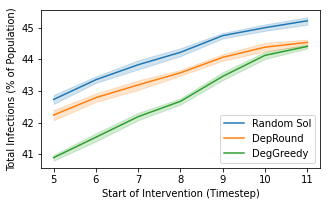

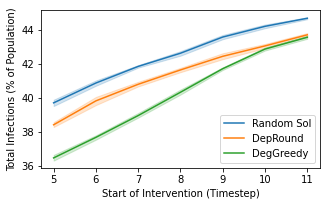

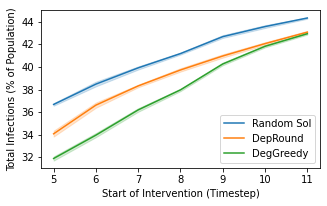

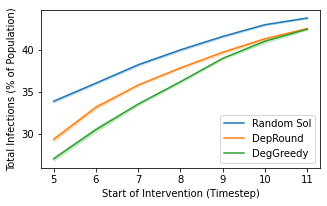

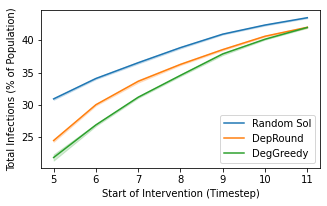

In [252]:
for k in [500,1000,1500,2000,2500]:
    fig, ax = plt.subplots(1,figsize=(5,3))
    
    sns.lineplot(data=df[df.budget==k],x="t",y="infected",hue="method", ax=ax)
    #ax.set_title(str(k))
    ax.set_ylabel("Total Infections (% of Population)")
    ax.set_xlabel("Start of Intervention (Timestep)")
    ax.legend(loc='lower right',title='')
    plt.gcf().subplots_adjust(bottom=0.15)

    plt.show()
    fig.savefig("../output/plots/vary_t_cville_" + str(k), dpi=300)
    
    #sns.lineplot(data=df[df.budget==k],x="t",y="peak",hue="method")
    #plt.title(str(k))
    #plt.show()(k))

    

## Charlottesville Epicurve

In [266]:
x = []

<======= SIR Initialization Complete =======>
2 78143 5368 47708 5368
3 74863 3280 53076 3280
4 73063 1800 56356 1800
5 72117 946 58156 946
6 71624 493 59102 493
7 71360 264 59595 264
8 71228 132 59859 132
9 71154 74 59991 74
10 71111 43 60065 43
11 71096 15 60108 15
12 71091 5 60123 5
13 71087 4 60128 4
14 71085 2 60132 2
15 71085 0 60134 0


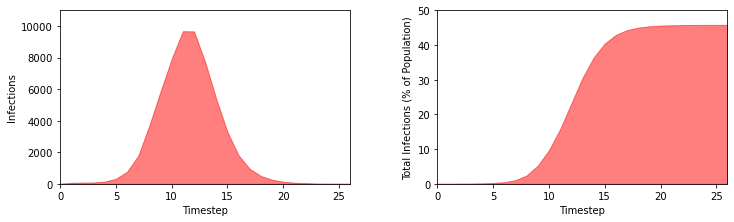

<======= SIR Initialization Complete =======>
2 78175 5336 47708 5336
3 74865 3310 53044 3310
4 73031 1834 56354 1834
5 72051 980 58188 980
6 71525 526 59168 526
7 71241 284 59694 284
8 71091 150 59978 150
9 71020 71 60128 71
10 70964 56 60199 56
11 70936 28 60255 28
12 70925 11 60283 11
13 70921 4 60294 4
14 70921 0 60298 0


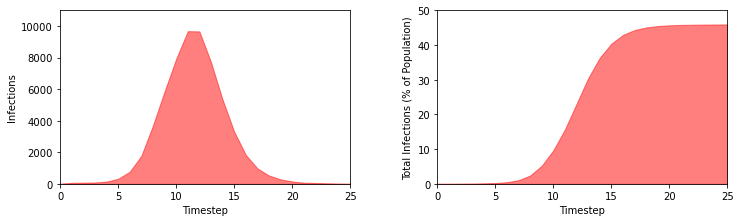

<======= SIR Initialization Complete =======>
2 78187 5324 47708 5324
3 74870 3317 53032 3317
4 72942 1928 56349 1928
5 71882 1060 58277 1060
6 71340 542 59337 542
7 71091 249 59879 249
8 70966 125 60128 125
9 70893 73 60253 73
10 70841 52 60326 52
11 70811 30 60378 30
12 70796 15 60408 15
13 70791 5 60423 5
14 70787 4 60428 4
15 70786 1 60432 1
16 70785 1 60433 1
17 70784 1 60434 1
18 70784 0 60435 0


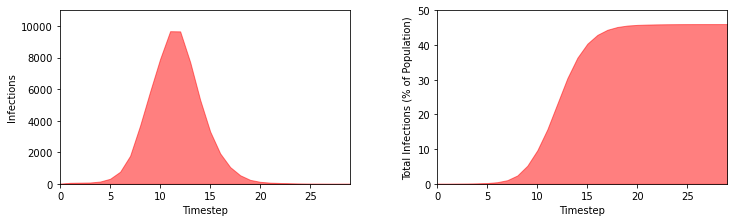

In [267]:
while len(x) < 30:
    (x,y1,y2) = generalized_mdp(G2,
                    p = .06,  # Required
                    budget= 200,  # Required
                    method= 'none',  # Required
                    MDP_iterations= -1,
                    num_shocks=20,  # Required
                    num_initial_infections=3,
                    initial_iterations= 1,  # Data
                    iterations_to_recover= 1,  # Required
                    cache= None,  # Data
                    from_cache= "a12.json",
                    shock_MDP= False,  # Required
                    visualization= True,  # Required
                    verbose= True)  # Required


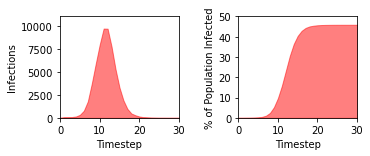

In [54]:
fig, ax = plt.subplots(1,2,figsize=(4.9,2))
fig.tight_layout()
plt.subplots_adjust(wspace = .5)
ax[0].set_xlim([0,len(y1)-1])
ax[0].set_ylim([0,11000])

ax[0].fill_between(x, y2, facecolor='red', color='red',alpha=0.5)
#ax[0].set_title("Epidemic Simulation, No Quarantine")
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Infections")

#y1 = [100.0*i/len(G2.nodes) for i in y1]
ax[1].set_xlim([0,len(y1)-1])
ax[1].set_ylim([0,50])

ax[1].fill_between(x, y1, facecolor='red',color='red',alpha=0.5)
#ax[1].set_title("Epidemic Simulation, No Quarantine")
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("% of Population Infected")

plt.savefig("epicurves.png",dpi=500,bbox_inches = "tight")
plt.show()

## Montgomery Epicurve

In [262]:
G = load_graph("montgomery")

<======= SIR Initialization Complete =======>
2 42836 2919 29702 2919
3 41234 1602 32621 1602
4 40366 868 34223 868
5 39896 470 35091 470
6 39629 267 35561 267
7 39484 145 35828 145
8 39404 80 35973 80
9 39372 32 36053 32
10 39358 14 36085 14
11 39350 8 36099 8
12 39346 4 36107 4
13 39343 3 36111 3
14 39341 2 36114 2
15 39341 0 36116 0


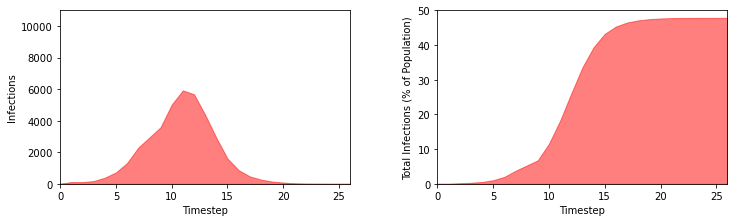

<======= SIR Initialization Complete =======>
2 42918 2837 29702 2837
3 41224 1694 32539 1694
4 40313 911 34233 911
5 39844 469 35144 469
6 39600 244 35613 244
7 39455 145 35857 145
8 39399 56 36002 56
9 39368 31 36058 31
10 39357 11 36089 11
11 39351 6 36100 6
12 39347 4 36106 4
13 39345 2 36110 2
14 39345 0 36112 0


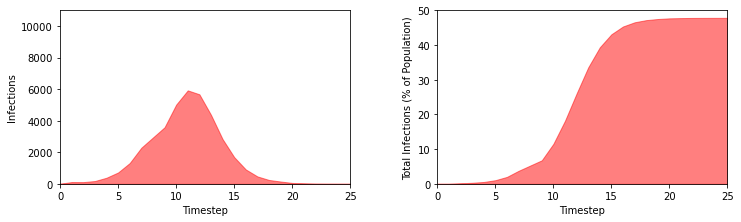

<======= SIR Initialization Complete =======>
2 42941 2814 29702 2814
3 41279 1662 32516 1662
4 40346 933 34178 933
5 39917 429 35111 429
6 39696 221 35540 221
7 39578 118 35761 118
8 39522 56 35879 56
9 39494 28 35935 28
10 39472 22 35963 22
11 39463 9 35985 9
12 39455 8 35994 8
13 39450 5 36002 5
14 39450 0 36007 0


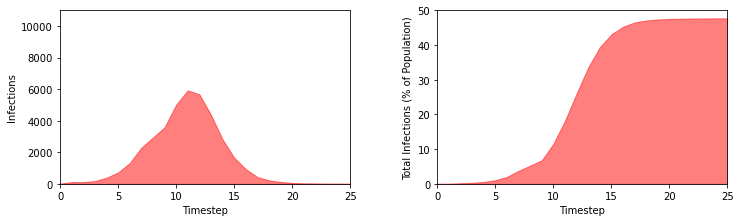

<======= SIR Initialization Complete =======>
2 42896 2859 29702 2859
3 41279 1617 32561 1617
4 40342 937 34178 937
5 39864 478 35115 478
6 39620 244 35593 244
7 39501 119 35837 119
8 39444 57 35956 57
9 39403 41 36013 41
10 39386 17 36054 17
11 39374 12 36071 12
12 39368 6 36083 6
13 39366 2 36089 2
14 39366 0 36091 0


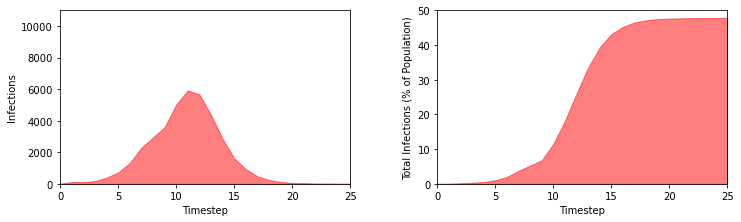

<======= SIR Initialization Complete =======>
2 42872 2883 29702 2883
3 41191 1681 32585 1681
4 40342 849 34266 849
5 39904 438 35115 438
6 39679 225 35553 225
7 39549 130 35778 130
8 39476 73 35908 73
9 39430 46 35981 46
10 39411 19 36027 19
11 39402 9 36046 9
12 39394 8 36055 8
13 39392 2 36063 2
14 39391 1 36065 1
15 39391 0 36066 0


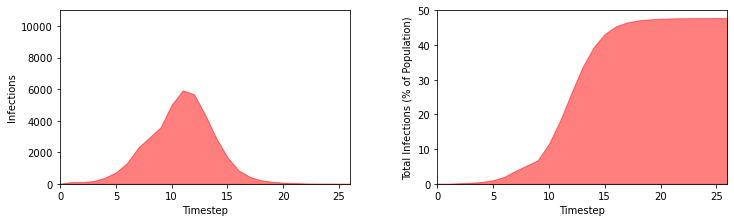

<======= SIR Initialization Complete =======>
2 42940 2815 29702 2815
3 41319 1621 32517 1621
4 40421 898 34138 898
5 39919 502 35036 502
6 39697 222 35538 222
7 39582 115 35760 115
8 39518 64 35875 64
9 39493 25 35939 25
10 39481 12 35964 12
11 39474 7 35976 7
12 39473 1 35983 1
13 39473 0 35984 0


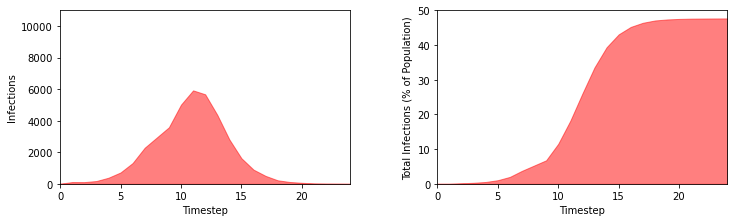

<======= SIR Initialization Complete =======>
2 42966 2789 29702 2789
3 41341 1625 32491 1625
4 40400 941 34116 941
5 39931 469 35057 469
6 39709 222 35526 222
7 39592 117 35748 117
8 39534 58 35865 58
9 39502 32 35923 32
10 39486 16 35955 16
11 39479 7 35971 7
12 39470 9 35978 9
13 39466 4 35987 4
14 39462 4 35991 4
15 39461 1 35995 1
16 39461 0 35996 0


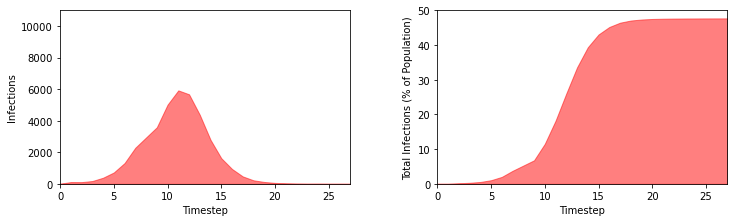

<======= SIR Initialization Complete =======>
2 42819 2936 29702 2936
3 41112 1707 32638 1707
4 40209 903 34345 903
5 39703 506 35248 506
6 39463 240 35754 240
7 39346 117 35994 117
8 39302 44 36111 44
9 39278 24 36155 24
10 39270 8 36179 8
11 39263 7 36187 7
12 39260 3 36194 3
13 39259 1 36197 1
14 39256 3 36198 3
15 39254 2 36201 2
16 39254 0 36203 0


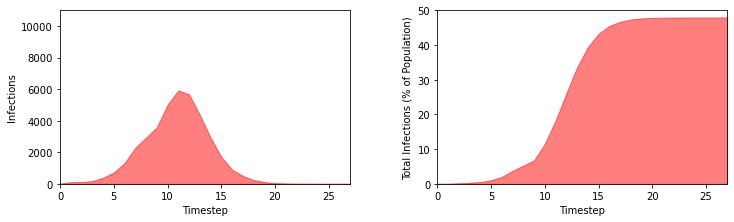

<======= SIR Initialization Complete =======>
2 42873 2882 29702 2882
3 41217 1656 32584 1656
4 40316 901 34240 901
5 39848 468 35141 468
6 39612 236 35609 236
7 39464 148 35845 148
8 39384 80 35993 80
9 39352 32 36073 32
10 39341 11 36105 11
11 39338 3 36116 3
12 39337 1 36119 1
13 39337 0 36120 0


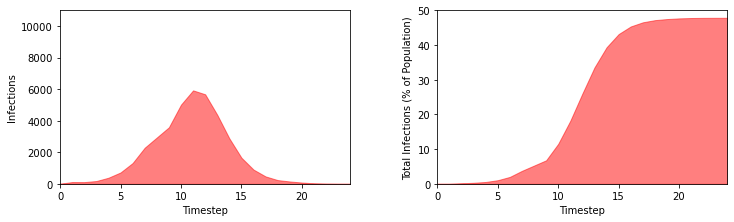

<======= SIR Initialization Complete =======>
2 42851 2904 29702 2904
3 41244 1607 32606 1607
4 40345 899 34213 899
5 39867 478 35112 478
6 39646 221 35590 221
7 39528 118 35811 118
8 39469 59 35929 59
9 39442 27 35988 27
10 39424 18 36015 18
11 39412 12 36033 12
12 39404 8 36045 8
13 39402 2 36053 2
14 39402 0 36055 0


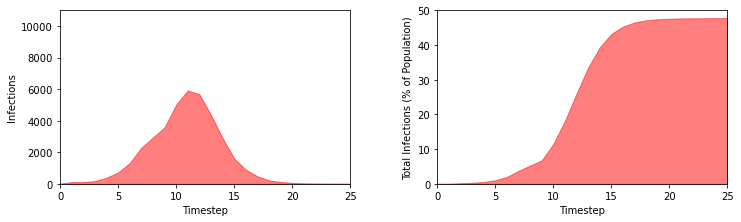

<======= SIR Initialization Complete =======>
2 42846 2909 29702 2909
3 41187 1659 32611 1659
4 40307 880 34270 880
5 39836 471 35150 471
6 39602 234 35621 234
7 39488 114 35855 114
8 39434 54 35969 54
9 39407 27 36023 27
10 39396 11 36050 11
11 39393 3 36061 3
12 39389 4 36064 4
13 39384 5 36068 5
14 39381 3 36073 3
15 39378 3 36076 3
16 39377 1 36079 1
17 39377 0 36080 0


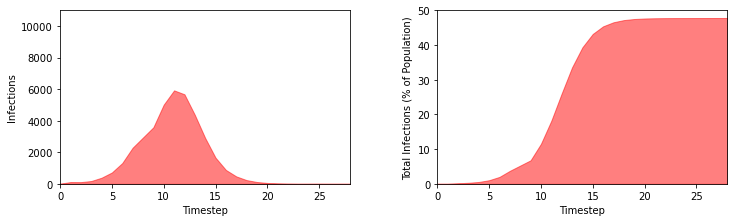

<======= SIR Initialization Complete =======>
2 42878 2877 29702 2877
3 41238 1640 32579 1640
4 40354 884 34219 884
5 39904 450 35103 450
6 39665 239 35553 239
7 39554 111 35792 111
8 39505 49 35903 49
9 39479 26 35952 26
10 39460 19 35978 19
11 39449 11 35997 11
12 39444 5 36008 5
13 39440 4 36013 4
14 39439 1 36017 1
15 39436 3 36018 3
16 39432 4 36021 4
17 39430 2 36025 2
18 39428 2 36027 2
19 39428 0 36029 0


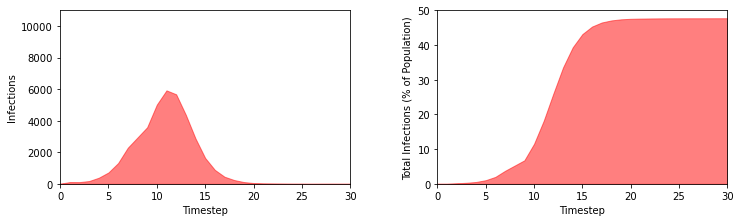

In [268]:
a = []

while len(a) < 30:
    (a,b1,b2) = generalized_mdp(G,
                    p = .078,  # Required
                    budget= 200,  # Required
                    method= 'none',  # Required
                    MDP_iterations= -1,
                    num_shocks=1,  # Required
                    num_initial_infections=3,
                    initial_iterations= 1,  # Data
                    iterations_to_recover= 1,  # Required
                    cache= None,  # Data
                    from_cache= "t12.json",
                    shock_MDP= False,  # Required
                    visualization= True,  # Required
                    verbose= True)  # Required


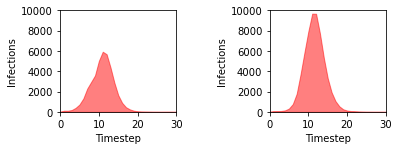

In [279]:
fig, ax = plt.subplots(1,2,figsize=(5.3,2))
fig.tight_layout()
plt.subplots_adjust(wspace = .8)
ax[0].set_xlim([0,30])
ax[0].set_ylim([0,10000])

ax[0].fill_between(a, b2, facecolor='red', color='red',alpha=0.5)
#ax[0].set_title("Epidemic Simulation, No Quarantine")
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Infections")

#y1 = [100.0*i/len(G2.nodes) for i in y1]
ax[1].set_xlim([0,30])
ax[1].set_ylim([0,10000])

ax[1].fill_between(x, y2, facecolor='red',color='red',alpha=0.5)
#ax[1].set_title("Epidemic Simulation, No Quarantine")
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Infections")

plt.savefig("combined_epicurves.png",dpi=500,bbox_inches = "tight")
plt.show()

In [281]:
y1[-1]

46.05583032944924

In [282]:
b1[-1]

47.747723869223535

In [6]:
generalized_mdp(G2,
                    p = .06,  # Required
                    budget= 200,  # Required
                    method= 'dependent',  # Required
                    MDP_iterations= -1,
                    num_shocks=20,  # Required
                    num_initial_infections=3,
                    initial_iterations= 1,  # Data
                    iterations_to_recover= 1,  # Required
                    cache= None,  # Data
                    from_cache= 'a5.json',
                    shock_MDP= False,  # Required
                    visualization= True,  # Required
                    verbose= True)  # Required


<======= SIR Initialization Complete =======>
2 127967 1876 1376 1876
3 124198 3652 3252 3652


KeyboardInterrupt: 

In [28]:

n = len(G2.nodes)
I = [i for i in range(n) if random.random() < .95]

In [29]:
V_1,V_2 = find_excluded_contours(G2,I,[])

In [30]:
P, Q = PQ_deterministic(G2,I,V_1,.078)

In [53]:
solver = pywraplp.Solver.CreateSolver("GLOP")
print(solver)

<ortools.linear_solver.pywraplp.Solver; proxy of <Swig Object of type 'operations_research::MPSolver *' at 0x7fdf291e1a20> >


In [59]:
prob = ProbMinExposed(G2,I,V_1,V_2,P,Q,2000,solver=solver)
prob2 = ProbMinExposed(G2,I,V_1,V_2,P,Q,2000)

In [60]:
a = time.time()
prob.solve_lp()
print(time.time()-a)

0.1303246021270752


In [61]:
a = time.time()
prob2.solve_lp()
print(time.time()-a)

0.021004915237426758


In [50]:
components = sorted(nx.connected_components(G), key = len, reverse=True)

In [51]:
to_rem = set()

for s in components:
    
    if len(s) <= 15:
        for node in s:
            G.remove_node(node)

In [42]:
a = list(G.nodes)

In [2]:
from ortools.linear_solver import pywraplp

In [3]:
solver = pywraplp.Solver.CreateSolver("GUROBI_LP")

In [4]:
print(solver)

None


In [28]:
['a' + str(i) + ".json" for i in range(5,12,1)]

['a5.json', 'a6.json', 'a7.json', 'a8.json', 'a9.json', 'a10.json', 'a11.json']

In [78]:
['t' + str(i) + ".json" for i in range(7,15,1)]

['t7.json',
 't8.json',
 't9.json',
 't10.json',
 't11.json',
 't12.json',
 't13.json',
 't14.json']

In [75]:
nx.write_edgelist(G, "../data/portland2.txt")

In [73]:
generalized_mdp(G,
                    p = .094,  # Required
                    budget= 300,  # Required
                    method= 'none',  # Required
                    MDP_iterations= -1,
                    num_shocks=150,  # Required
                    num_initial_infections=50,
                    initial_iterations= 5,  # Data
                    iterations_to_recover= 1,  # Required
                    cache= None,  # Data
                    from_cache= None,
                    shock_MDP= False,  # Required
                    visualization= True,  # Required
                    verbose= True)  # Required

0 1233041 50 0


KeyboardInterrupt: 

In [1]:
G = load_graph("montgomery")

NameError: name 'load_graph' is not defined

In [87]:
from string import ascii_lowercase

In [88]:
for c in ascii_lowercase:
    for c1 in ['a','b']:
        generalized_mdp(G,
                        p = .078,  # Required
                        budget= 1,  # Required
                        method= 'none',  # Required
                        MDP_iterations= -1,
                        num_shocks=8,  # Required
                        num_initial_infections=5,
                        initial_iterations= 5,  # Data
                        iterations_to_recover= 1,  # Required
                        cache= c+c1,  # Data
                        from_cache= None,
                        shock_MDP= False,  # Required
                        visualization= False,  # Required
                        verbose= False)  # Required


<Figure size 432x288 with 0 Axes>

In [21]:
SIM_RETURN = namedtuple("SIM_RETURN", ["num_contracted", "peak_infected", "simulation_length"])

In [263]:
def generalized_mdp(G: nx.graph,
                    p: float,  # Required
                    budget: int,  # Required
                    method: str,  # Required
                    MDP_iterations: int,
                    num_shocks: int,  # Required
                    num_initial_infections: int,
                    initial_iterations: int,  # Data
                    iterations_to_recover: int = 1,  # Required
                    cache: str = None,  # Data
                    from_cache: str = None,
                    shock_MDP: bool = False,  # Required
                    visualization: bool = False,  # Required
                    verbose: bool = False,
                    **kwargs):  # Required
    S = set()
    I = set()
    R = set()
    infected_queue = []

    x = []
    y1 = []
    y2 = []
    y3 = []
    
    # Data set up
    if from_cache:
        with open(PROJECT_ROOT / "data" / "SIR_Cache" / from_cache, 'r') as infile:
            j = json.load(infile)
            (S, infected_queue, R) = (
                set(j["S"]), j["I_Queue"], set(j["R"]))
            (x,y1,y2,y3) = (j['x'], j['y1'], j['y2'], j['y3'])
            # Make infected_queue a list of sets
            infected_queue = [set(s) for s in infected_queue]
            I = I.union(*infected_queue)
            if len(infected_queue) != iterations_to_recover:
                raise ValueError(
                    "Infected queue length must be equal to iterations_to_recover")

    else:
        # initialize S, I, R
        I = set(random.sample(list(G.nodes), num_initial_infections))
        S = set(list(G.nodes)).difference(I)
        R = set()

        # initialize the queue for recovery
        infected_queue = [set() for _ in range(iterations_to_recover)]
        infected_queue.pop(0)
        infected_queue.append(I)
        
        if visualization:
            x.append(0)
            y1.append(len(R))
            y2.append(len(I))
            y3.append(len(S))
    
        if verbose:
            print(0, len(S), len(I), len(R))

        for t in range(initial_iterations):

            full_data = EoN.basic_discrete_SIR(
                G=G, p=p+(1-p)*int(t==0), initial_infecteds=I, initial_recovereds=R, tmin=0, tmax=1, return_full_data=True)

            # update susceptible, infected, and recovered sets
            S = set([k for (k, v) in full_data.get_statuses(
                time=1).items() if v == 'S'])
            new_I = set([k for (k, v) in full_data.get_statuses(
                time=1).items() if v == 'I'])

            (S, new_I) = shock(S, new_I, num_shocks)

            to_recover = infected_queue.pop(0)
            infected_queue.append(new_I)

            I = I.difference(to_recover)
            I = I.union(new_I)
            R = R.union(to_recover)
            
            if visualization:
                x.append(t+1)
                y1.append(len(R))
                y2.append(len(I))
                y3.append(len(S))
        
            if verbose:
                print(t+1, len(S), len(I), len(R), len(new_I))

        if cache:
            save = {
                "S": list(S),
                # convert list of sets into list of queue
                "I_Queue": [list(s) for s in infected_queue],
                "R": list(R),
                "x": x,
                "y1": y1,
                "y2": y2,
                "y3": y3
            }
            name = cache + str(initial_iterations) + ".json"
            if len(I) >= 500:
                with open(PROJECT_ROOT / "data" / "SIR_Cache" / "time_trials" / name, 'w') as outfile:
                        json.dump(save, outfile)

    # Running the simulation
    peak = 0
    total_iterated = 0
    Q_infected = []
    Q_susceptible = []

    if MDP_iterations == -1:
        iterator = itertools.count(start=0, step=1)
    else:
        iterator = range(MDP_iterations)

    if verbose:
        print("<======= SIR Initialization Complete =======>")

    for t in iterator:

        # get recommended quarantine
        (val, recommendation) = to_quarantine(
            G, I, R, budget, method=method, p=p)

        # go through one step of the disease spread
        # (S, I, R) = MDP_step(G, S, I, R, Q_infected, Q_susceptible, p=p)

        full_data = EoN.basic_discrete_SIR(G=G, p=p, initial_infecteds=I, initial_recovereds=list(
            R) + Q_infected + Q_susceptible, tmin=0, tmax=1, return_full_data=True)

        S = set([k for (k, v) in full_data.get_statuses(
            time=1).items() if v == 'S'])
        new_I = set([k for (k, v) in full_data.get_statuses(
            time=1).items() if v == 'I'])

        if shock_MDP:
            (S, new_I) = shock(S, new_I, num_shocks)

        to_recover = infected_queue.pop(0)
        infected_queue.append(new_I)

        I = I.difference(to_recover)
        I = I.union(new_I)
        R = R.union(to_recover)

        if visualization:
            x.append(len(x)+1)
            y1.append(len(R))
            y2.append(len(I))
            y3.append(len(S))
        
        if verbose:
            print(t+initial_iterations+1,len(S), len(I), len(R), len(new_I))
        
        if len(I) > peak:
            peak = len(I)
        
        if cache:
            save = {
                "S": list(S),
                # convert list of sets into list of queue
                "I_Queue": [list(s) for s in infected_queue],
                "R": list(R),
                "x": x,
                "y1": y1,
                "y2": y2,
                "y3": y3
            }
            name = cache+str(t+initial_iterations+1) + ".json"
            if len(I) >= 500:
                with open(PROJECT_ROOT / "data" / "SIR_Cache" / "time_trials" / name, 'w') as outfile:
                    json.dump(save, outfile)
        
        # Loop until no infected left.
        if (MDP_iterations == -1) & (len(I) == 0):
            total_iterated = t + initial_iterations + 1
            break
        
        # people are quarantined (removed from graph temporarily after the timestep)
        for (k, v) in recommendation.items():
            if v == 1:
                if k in S:
                    S.remove(k)
                    Q_susceptible.append(k)
                elif k in I:  # I_t is undefined
                    I.remove(k)
                    Q_infected.append(k)
    
    #while 
    
    if visualization:
        colors = ["red", "limegreen", "deepskyblue"]
        labels = ["Infected", "Recovered", "Susceptible"]

        fig, ax = plt.subplots(1,2,figsize=(10,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace = .3)
        ax[0].set_xlim([0,len(y1)-1])
        ax[0].set_ylim([0,11000])

        ax[0].fill_between(x, y2, facecolor='red', color='red',alpha=0.5)
        #ax[0].set_title("Epidemic Simulation, No Quarantine")
        ax[0].set_xlabel("Timestep")
        ax[0].set_ylabel("Infections")
        
        y1 = [100.0*i/len(G.nodes) for i in y1]
        ax[1].set_xlim([0,len(y1)-1])
        ax[1].set_ylim([0,50])
        
        ax[1].fill_between(x, y1, facecolor='red',color='red',alpha=0.5)
        #ax[1].set_title("Epidemic Simulation, No Quarantine")
        ax[1].set_xlabel("Timestep")
        ax[1].set_ylabel("Total Infections (% of Population)")
        
        plt.savefig("epicurves.png",dpi=500,bbox_inches = "tight")

        plt.show()
        return (x,y1,y2)
    # TODO: Check return statement
    return SIM_RETURN(len(R), peak, total_iterated)

In [23]:
fig = plt.gcf()


<Figure size 432x288 with 0 Axes>

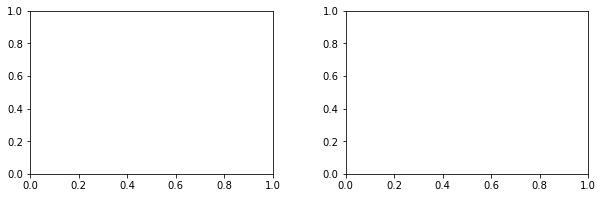

In [38]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace = .3)
plt.show()

In [17]:
type(ax[1])

matplotlib.axes._subplots.AxesSubplot

In [5]:
S, I, R = initial(from_cache="Q4data.json")
print(len(I))

421


0 421 74686 350
1 834 73752 771
2 1727 71992 1650
3 3189 68760 3412
4 5534 63189 6643
5 8074 55067 12225
6 8618 46386 20359
7 6667 39653 29051
8 3826 35754 35783
9 1808 33886 39669
10 716 33125 41523
11 241 32842 42277
12 82 32732 42547
13 18 32695 42644


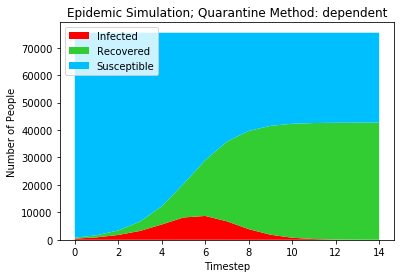

(42674, 8692, 14)

In [24]:
MDP(G, 100, S, I, R, p=0.1, iterations=-1, visualization=True, method="dependent", verbose=True)

In [8]:
df1 = pd.read_csv("../output/Q4_csvs/george_random_data.csv")
df2 = pd.read_csv("../output/Q4_csvs/george_degree_data.csv")
df3 = pd.read_csv("../output/Q4_csvs/george_dependent_data.csv")
df4 = pd.read_csv("../output/Q4_csvs/george_random_data2.csv")
df5 = pd.read_csv("../output/Q4_csvs/george_degree_data2.csv")
df6 = pd.read_csv("../output/Q4_csvs/george_dependent_data2.1.csv")
df7 = pd.read_csv("../output/Q4_csvs/george_random_data3.csv")
df8 = pd.read_csv("../output/Q4_csvs/george_degree_data3.csv")
df9 = pd.read_csv("../output/Q4_csvs/george_dependent_data3.csv")

In [16]:
print(df7.shape)
print(df8.shape)
print(df9.shape)

(40, 19)
(40, 19)
(40, 19)


In [9]:
df1 = pd.concat([df1,df4,df7]).reset_index(drop=True)
df2 = pd.concat([df2,df5,df8]).reset_index(drop=True)
df3 = pd.concat([df3,df6,df9]).reset_index(drop=True)


C:\Users\George Li\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [20]:
ks = np.array(df1['k'])
print(ks)
a=43000
b=9000
none_total = [a for _ in ks]
none_peak = [b for _ in ks]
#print(none_total)
#print(none_peak)

[ 500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.  610.
  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.  730.
  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.  840.  850.
  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.  960.  970.
  980.  990. 1000. 1010. 1020. 1030. 1040. 1050. 1060. 1070. 1080. 1090.
 1100. 1110. 1120. 1130. 1140. 1150. 1160. 1170. 1180. 1190. 1200. 1210.
 1220. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300. 1310. 1320. 1330.
 1340. 1350. 1360. 1370. 1380. 1390. 1400. 1410. 1420. 1430. 1440. 1450.
 1460. 1470. 1480. 1490. 1500. 1510. 1520. 1530. 1540. 1550. 1560. 1570.
 1580. 1590. 1600. 1610. 1620. 1630. 1640. 1650. 1660. 1670. 1680. 1690.
 1700. 1710. 1720. 1730. 1740. 1750. 1760. 1770. 1780. 1790. 1800. 1810.
 1820. 1830. 1840. 1850. 1860. 1870. 1880. 1890. 1900. 1910. 1920. 1930.
 1940. 1950. 1960. 1970. 1980. 1990. 2000.  100.  110.  120.  130.  140.
  150.  160.  170.  180.  190.  200.  210.  220.  2

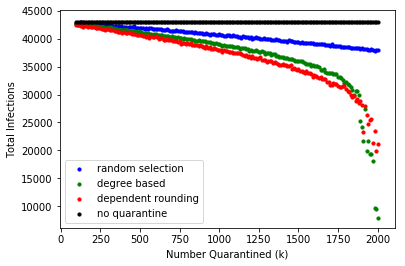

In [21]:
fig, ax = plt.subplots()

ax.scatter(df1['k'], df1['avg_total'], c='blue', s=10)

ax.scatter(df2['k'], df2['avg_total'], c='green', s=10)

ax.scatter(df3['k'], df3['avg_total'], c='red', s=10)

ax.scatter(ks, none_total, c='black', s=10)

#ax.set_title("Total Infections vs. Number Quarantined for Different Methods")
ax.set_xlabel("Number Quarantined (k)")
ax.set_ylabel("Total Infections")

ax.legend(['random selection','degree based','dependent rounding','no quarantine'])


plt.show()

#fig.savefig("../output/Q4plots/compare_total1", dpi=400)

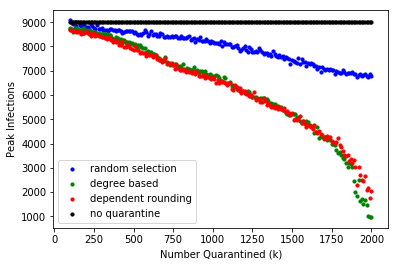

In [22]:
fig1, ax1 = plt.subplots()

ax1.scatter(df1['k'], df1['avg_peak'], c='blue', s=10)

ax1.scatter(df2['k'], df2['avg_peak'], c='green', s=10)

ax1.scatter(df3['k'], df3['avg_peak'], c='red', s=10)

ax1.scatter(ks, none_peak, c = 'black', s=10)

#ax1.set_title("Peak Infections vs. Number Quarantined for Different Methods")
ax1.set_xlabel("Number Quarantined (k)")
ax1.set_ylabel("Peak Infections")

ax1.legend(['random selection','degree based','dependent rounding', 'no quarantine'])

plt.show()

#fig1.savefig("../output/Q4plots/compare_peak1", dpi=400)

In [26]:
(S, I, R) = initial(G, from_cache="Q4data.json")

In [19]:
print(a)
b

43010.6


9062.0

0 421 74686 350
1 878 73808 771
2 1808 72000 1649
3 3532 68468 3457
4 6229 62239 6989
5 8803 53436 13218
6 8866 44570 22021
7 6243 38327 30887
8 3242 35085 37130
9 1456 33629 40372
10 619 33010 41828
11 243 32767 42447
12 86 32681 42690
13 31 32650 42776
14 11 32639 42807
15 4 32635 42818
16 2 32633 42822


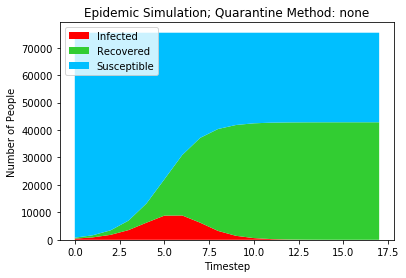

42824
8866
17
0 421 74686 350
1 961 73725 771
2 2045 71680 1732
3 4018 67662 3777
4 6782 60880 7795
5 9145 51735 14577
6 8552 43183 23722
7 5598 37585 32274
8 2888 34697 37872
9 1250 33447 40760
10 511 32936 42010
11 221 32715 42521
12 86 32629 42742
13 35 32594 42828
14 17 32577 42863
15 3 32574 42880


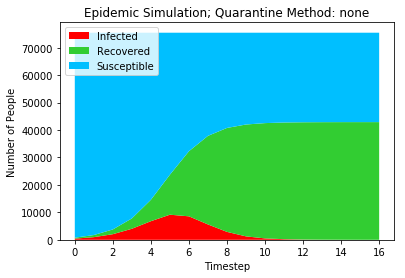

42883
9145
16
0 421 74686 350
1 914 73772 771
2 1881 71891 1685
3 3739 68152 3566
4 6647 61505 7305
5 9137 52368 13952
6 8846 43522 23089
7 5929 37593 31935
8 2907 34686 37864
9 1338 33348 40771
10 508 32840 42109
11 199 32641 42617
12 76 32565 42816
13 26 32539 42892
14 16 32523 42918
15 12 32511 42934
16 7 32504 42946
17 4 32500 42953
18 1 32499 42957


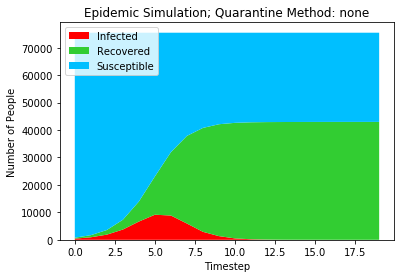

42958
9137
19
0 421 74686 350
1 900 73786 771
2 1938 71848 1671
3 3960 67888 3609
4 6762 61126 7569
5 9184 51942 14331
6 8818 43124 23515
7 5859 37265 32333
8 2952 34313 38192
9 1240 33073 41144
10 513 32560 42384
11 210 32350 42897
12 89 32261 43107
13 38 32223 43196
14 8 32215 43234
15 5 32210 43242


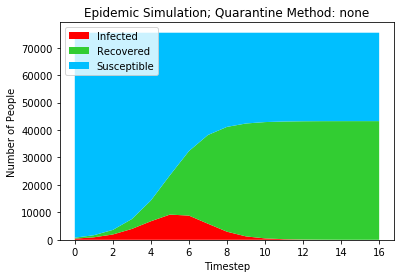

43247
9184
16
0 421 74686 350
1 895 73791 771
2 1888 71903 1666
3 3503 68400 3554
4 6263 62137 7057
5 8774 53363 13320
6 8978 44385 22094
7 6333 38052 31072
8 3240 34812 37405
9 1466 33346 40645
10 596 32750 42111
11 258 32492 42707
12 101 32391 42965
13 41 32350 43066
14 16 32334 43107
15 8 32326 43123
16 7 32319 43131
17 2 32317 43138
18 1 32316 43140


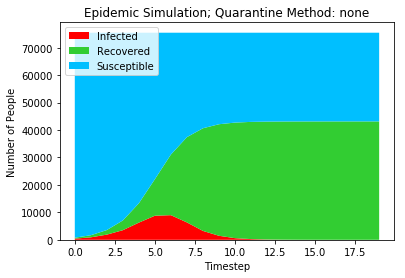

43141
8978
19


In [18]:
a = 0
b = 0

for i in range(5):
    (x,y,z) = MDP(G, 0, S, I, R, p=0.1, iterations=-1, visualization=True, method="none", verbose=True)
    a+=x
    b+=y
    
    print(x)
    print(y)
    print(z)
    
a/=5
b/=5

701 74162 594
1487 72275 1295
2741 69499 2836
4713 64751 5598
6891 57825 10350
8196 49597 17280
7086 42467 25533
4587 37834 32655
2414 35378 37277
1102 34238 39731
416 33780 40874
101 33641 41322
0 33752 41456
0 33974 41483
0 33974 41483


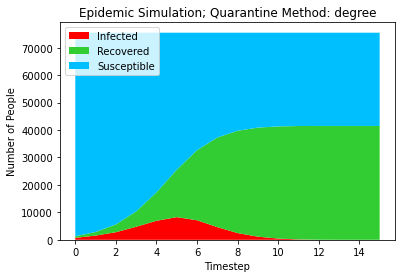

In [9]:
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="degree")

In [5]:
import time
a = time.time()
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="dependent", verbose=True)
print(time.time()-a)

421 74686 350


AttributeError: 'NoneType' object has no attribute 'NumVar'

In [ ]:
"""Stop here"""

In [18]:
#G = load_graph("montgomery")
n = len(G2.nodes)
I = [i for i in range(n) if random.random() > .99]

In [19]:
COSTS = np.ones(n)

In [20]:
V_1,V_2 = find_excluded_contours(G2,I,[])

In [41]:
degrees = []

for u in V_1:
    count = 0
    for v in G.neighbors(u):
        if v in V_2:
            count+=1

    degrees.append((count,u))

degrees.sort()
degrees.reverse()

sol = {}

for i in range(len(V_1)):
    if i < 100:
        sol[degrees[i][1]] = 1
    else:
        sol[degrees[i][1]] = 0

In [43]:
a = 0
for (k,v) in sol.items():
    a+=v
a

100

In [37]:
arr[:5]

[(65, 3751), (62, 27236), (61, 35651), (61, 34538), (60, 18733)]

In [101]:
P,Q = PQ_deterministic(G=G2,I=I,V1=V_1,p=0.08)

In [102]:
prob = ProbMinExposed(G2,I,V_1,V_2,P,Q,2000,COSTS)
prob.solve_lp()
prob.objectiveVal

2249.3008640055355

In [22]:
print(prob.costs.sum())

75457.0


In [24]:
a = 0
for (k,v) in prob.partials.items():
    a += v
print(a)

2877


In [103]:
a = prob.getVariables()
#print(a.sum())
(val, c) = basic_non_integer_round(prob)
#print(c.sum())
#print(val1)
print(val)
#prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
#(val2, b) = iterated_round(prob,100)
#prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
#(val3, d) = optimized_iterated_round(prob, 100)
#print(val2)
#print(val3)
#for i in range(len(a)):
#    if (a[i] != 0) & (a[i] != 1):
#        print(str(a[i]) + " " + str(c[i]))
    
#print(len(a))
#a.sum()

2388.990848003932


In [21]:
sample = random.sample(range(0, len(V_1)), 800)
#just to not break stuff
prob.solve_lp()

for u in range(0,len(V_1)):
    #print(u)
    if u in sample:
        prob.setVariable(u, 0)
    else:
        prob.setVariable(u, 1)
#print(prob.partials)
print(len(V_1))
print(len(prob.partials))
print(prob.costs)
print(len(prob.costs))
#print(prob.filled())

prob.solve_lp()

3677
3677
[1. 1. 1. ... 1. 1. 1.]
75457


ValueError: Infeasible solution

In [49]:
for (k,v) in c.items(): 
    print(k)
    print(v)
    break

32768
0.0


In [20]:
print(len(V_1))
len(b)

11298


11298

In [13]:
a1=0
a2=0
a3=0
m1=10000000000
m2=10000000000
m3=10000000000

k=20

for i in range(k):
    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    optimized_iterated_round(prob, 500)
    prob.solve_lp()
    a1 += prob.objectiveVal
    
    if prob.objectiveVal < m1:
        m1 = prob.objectiveVal
    
    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    iterated_round(prob, 500)
    prob.solve_lp()
    a2 += prob.objectiveVal
    
    if prob.objectiveVal < m2:
        m2 = prob.objectiveVal

    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    basic_non_integer_round(prob)
    prob.solve_lp()
    a3 += prob.objectiveVal
        
    if prob.objectiveVal < m3:
        m3 = prob.objectiveVal
    
    print(i)
    
a1 /= k
a2 /= k
a3 /= k

print("Average: " + str(a1) + " " + str(a2) + " " + str(a3))
print("Best: " + str(m1) + " " + str(m2) + " " + str(m3))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Average: 13995.412500000286 13970.625000000266 14023.225000000264
Best: 13966.450000000283 13950.600000000224 13992.000000000284


In [8]:
#p1 = defaultdict(lambda: .7)
#q = defaultdict(lambda: defaultdict(lambda : .7))
#prob = ProbMinExposed(G,I0,V_1,V_2,p1,q,10,COSTS)

In [ ]:
#test simplify

a = 1
b = 0

total_a = 0
total_b = 0

n=1000000

for i in range(n):
    (x,y,new_a,new_b) = simplify(a,b)
    
    if x==-1:
        total_a += new_a
        total_b += y
    elif y==-1:
        total_a += x
        total_b += new_b
    else:
        total_a += x
        total_b += y

print(str(total_a/n) + " " + str(a))
print(str(total_b/n) + " " + str(b))

In [ ]:
#test D
p = [.5,.5,.25,.6,.15]

n=10000
total = np.zeros(5)

for i in range(n):
    a = D(p)
    if np.sum(a) != np.sum(p):
        print("oof")
    #print(p)
    total += a
    
total/=n
print(total)

In [ ]:
#test D_prime
p = [.5,.4,.25,.75,.7]

n=5000
total = np.zeros(5)

for i in range(n):
    a = D(p)
    if (np.sum(a) != math.floor(np.sum(p))) & (np.sum(a) != math.ceil(np.sum(p))):
        print("oof")
    #print(p)
    total += a
    
total/=n
print(total)